In [202]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D,Input,Dense, Reshape, ReLU, Permute
from keras.utils.vis_utils import plot_model
import numpy as np
import pandas as pd
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

tf.random.set_seed(0)
np.random.seed(0)

In [203]:
# GLOBAL VARIABLES

MAX_LEN = 75
MIN_LEN = 0

TASK_TYPE = 'DNA'
MAX_LEN_PROTEIN = MAX_LEN // 3 - 6
MIN_LEN_PROTEIN = MIN_LEN

SEQ_LENGTH = MAX_LEN
DIM = 90
KERNEL_SIZE = 5
BATCH_SIZE = 128
N_CHAR = 5
NOISE_SHAPE = 128

In [204]:
# Check that the product SEQ_LENGTH * DIM is not greater than this number. Determined experimentally (given by the RAM capacity on this machine)
MAX_RESOURCE  = 8200 
SEQ_LENGTH * DIM

6750

### Load data Functions

In [205]:
import numpy as np
import pandas as pd

def get_sequences(path = None, split = 0.2, min_len = MIN_LEN, max_len = MAX_LEN_PROTEIN):
    if path is None:
        path = '/content/drive/My Drive/Colab Notebooks/FB-GAN_496/data/2018-06-06-ss.cleaned.csv'

    df = pd.read_csv(path)
    input_seqs, target_seqs = df[['seq', 'sst8']][(df.len >= min_len) & (df.len <= max_len) & (~df.has_nonstd_aa)].values.T
    seq_train, seq_test, target_train, target_test = train_test_split(input_seqs, target_seqs, test_size= split,random_state=1)
    
    return seq_train,seq_test,target_train,target_test

def get_dataset(sequences, batch_size = BATCH_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices(sequences)
    dataset = dataset.shuffle(sequences.shape[0], seed=0).batch(batch_size)
    return dataset


In [206]:
import numpy as np
import pandas as pd
from keras.preprocessing.sequence import pad_sequences


class OneHot_Seq:
    def __init__(self, letter_type='amino acids', letters = None, max_length=MAX_LEN):
        """
        :param letter_type: str 'amino acids' or 'DNA'. If a different type is used, provide custom letters.
        :param max_length: int maximum length of a sequence. Sequences will be padded to this length.
        """

        if letter_type == 'amino acids':
            self.letters = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T',
                            'W', 'Y', 'V']
        elif letter_type == 'DNA':
            self.letters = ['A', 'T', 'C', 'G']

        else:
            assert letters is not None
            self.letters = letters

        self.letters_dict = {f'{aa}': i + 1 for i, aa in enumerate(self.letters)}
        self.invert_dict = {v: k for k, v in self.letters_dict.items()}
        self.invert_dict[0] = 'P'

        self.max_length = max_length

    def _parse_pad_sequences(self, sequences):

        parse = lambda seq: np.array([a for a in seq])
        parsed = pd.DataFrame(sequences).iloc[:, 0].apply(parse)

        for i in range(parsed.shape[0]):
            parsed[i] = np.vectorize(self.letters_dict.get)(parsed[i])

        parsed = pad_sequences(parsed, maxlen=self.max_length, value=0, padding='post')

        return parsed

    def seq_to_onehot(self, sequences):
        """
        Return an array of one-hot encodings from sequence strings.
        :param sequences: ndarray of strings, shape = (N,1) where N is the number of samples
        :return: array of onehot encoded sequences, shape = (N, max_length, amino_acids)
        """
        sequences = self._parse_pad_sequences(sequences)
        onehot = []

        for seq in sequences:
            onehot_seq = np.zeros((seq.size, len(self.letters) + 1))
            onehot_seq[np.arange(seq.size), seq] = 1
            onehot.append(onehot_seq)

        return np.array(onehot)

    def onehot_to_seq(self, sequences):
        """
        Returns an array of strings from one-hot encoding.
        :param sequences: ndarray of shape (N, max_length, amino_acids) where N is the number of samples
        :return: array of strings of shape (N, 1)
        """
        if sequences.ndim == 2:
            sequences = np.argmax(sequences, axis=1)
            sequences = np.vectorize(self.invert_dict.get)(sequences)
            decoded_sequences = [''.join([aa for aa in sequences])]
            return decoded_sequences

        sequences = np.argmax(sequences, axis=2)
        sequences = np.vectorize(self.invert_dict.get)(sequences)
        decoded_sequences = [[''.join([aa for aa in seq])] for seq in sequences]

        return decoded_sequences


#### Protein to DNA

In [207]:
DNA_protein_MAP = {
            'ATA': 'I', 'ATC': 'I', 'ATT': 'I', 'ATG': 'M',
            'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T',
            'AAC': 'N', 'AAT': 'N', 'AAA': 'K', 'AAG': 'K',
            'AGC': 'S', 'AGT': 'S', 'AGA': 'R', 'AGG': 'R',
            'CTA': 'L', 'CTC': 'L', 'CTG': 'L', 'CTT': 'L',
            'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P',
            'CAC': 'H', 'CAT': 'H', 'CAA': 'Q', 'CAG': 'Q',
            'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R',
            'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V',
            'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A',
            'GAC': 'D', 'GAT': 'D', 'GAA': 'E', 'GAG': 'E',
            'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G',
            'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S',
            'TTC': 'F', 'TTT': 'F', 'TTA': 'L', 'TTG': 'L',
            'TAC': 'Y', 'TAT': 'Y', 'TAA': 'P', 'TAG': 'P',
            'TGC': 'C', 'TGT': 'C', 'TGA': 'P', 'TGG': 'W',
        }

protein_DNA_MAP = {v: k for k, v in DNA_protein_MAP.items()}
protein_DNA_MAP['P'] = 'TAG'


def protein_to_DNA(protein_sequences):
    global protein_DNA_MAP

    parsed = parse(protein_sequences)

    DNA_sequences = []
 
    if type(parsed[0]) in (str, np.str_):
        DNA_merged = ''.join([a for a in parsed])
        DNA_sequences += ['ATG'  +  DNA_merged + "TAG"]
        return DNA_sequences

    for seq in parsed:
        DNA = [protein_DNA_MAP[a] for a in seq]
        DNA_merged = ''.join([a for a in DNA])
        DNA_sequences += ['ATG'  +  DNA_merged + "TAG"]

    DNA_sequences = np.array(DNA_sequences).reshape(-1,1)
    return DNA_sequences

def parse(sequences):
    if type(sequences) == str:
        parsed = np.array([a for a in sequences])
        return parsed

    parse = lambda seq: np.array([a for a in seq])
    parsed = pd.DataFrame(sequences).iloc[:,0].apply(parse).to_numpy()

    return parsed


### Load Dataset


#### Protein

In [208]:
# X_train,X_test,y_train,y_test = get_sequences(split=0.05)
# print(len(X_train))

# X = X_train 
# OneHot = OneHot_Seq()
# real_sequences = OneHot.seq_to_onehot(X)

#### DNA

In [222]:
# Load protein sequences and shuffle them
X_train,X_test,y_train,y_test = get_sequences(split=0.05)
X_train = X_train.tolist()

print(f'Number of training samples: {len(X_train)}')
np.random.shuffle(X_train)

# Translate to DNA encoding
X = protein_to_DNA(X_train)
print(f'Example of translated DNA sequences: \n {X[:3]}')

# One Hot encode into 5 categories, ATCG and P for padded positions
OneHot = OneHot_Seq(letter_type= 'DNA')
real_sequences = OneHot.seq_to_onehot(X)
real_sequences

print(f'OneHot encoding of DNA sequences: {real_sequences[0]}')

Number of training samples: 7497
Example of translated DNA sequences: 
 [['ATGGCTTTGTGGGGTTTTTTTTAGGTTTTGTAG']
 ['ATGAAGATGGATTCTTTTTTGGATATGCAGTTGTAG']
 ['ATGGCTTCTCGTTAGGCTATTTTGTATGCTTTGTTGTCTTCTTCTTAG']]
OneHot encoding of DNA sequences: [[0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [

#### Synthetic dataset
Repeats one amino acid sequence over and over.

In [210]:
# synt_seq = ['RGRLRGRL'] * 2000
# synt_seq = np.array(synt_seq)

# OneHot = OneHot_Seq()
# real_sequences = OneHot.seq_to_onehot(synt_seq)

#### Synthetic - 4 amino acids

In [211]:
# amino_acids_4 = ['A', 'R', 'N', 'D']

# synt_seq1 = ['ARNDARNDARNDARND'] * 5000
# synt_seq2 = ['ARNDARNDNDNDNDND'] * 5000
# synt_seq = synt_seq1 + synt_seq2
# np.random.shuffle(synt_seq)

# OneHot = OneHot_Seq(amino_acids = amino_acids_4)
# real_sequences = OneHot.seq_to_onehot(synt_seq)

# real_sequences.shape

### GAN

In [212]:
def softmax(logits):
    shape = tf.shape(logits)
    res = tf.nn.softmax(tf.reshape(logits, [-1,N_CHAR]))
    return tf.reshape(res, shape)

class ResidualBlock(tf.keras.layers.Layer):

    def __init__(self):
        super(ResidualBlock, self).__init__()
        self.relu = ReLU()
        self.conv1d_1 = Conv1D(filters=DIM, kernel_size=KERNEL_SIZE, padding='same', strides=1, activation='relu')
        self.conv1d_2 = Conv1D(filters=DIM, kernel_size=KERNEL_SIZE, padding='same', strides=1)

    def __call__(self,X,alpha = 0.3):
        x = self.relu(X)
        x = self.conv1d_1(x)
        x = self.conv1d_2(x)
        return x + alpha*x

class Generator(tf.keras.Model):

    def __init__(self):
        """
        implementation of Generator
        :param input_size: size of the sequence (input noise)
        """
        super().__init__(name='generator')

        self.model = tf.keras.models.Sequential()
        self.model.add(Input(shape = (NOISE_SHAPE,), batch_size = BATCH_SIZE))
        self.model.add(Dense(units = DIM*SEQ_LENGTH))
        self.model.add(Reshape((SEQ_LENGTH, DIM)))

        self.model.add(ResidualBlock())
        self.model.add(ResidualBlock())
        self.model.add(ResidualBlock())
        self.model.add(ResidualBlock())
        self.model.add(ResidualBlock())

        self.model.add(Conv1D(filters = N_CHAR, kernel_size = 1))

    def __call__(self, inputs):
        x = self.model(inputs)
        x = softmax(x)
        return x

class Discriminator(tf.keras.Model):

    def __init__(self, clip = 1):
        """
        implementation of Discriminator
        :param clip: value to which you clip the gradients (or False)
        """
        super().__init__(name='discriminator')

        self.model = tf.keras.models.Sequential()
        self.model.add(Input(shape = (SEQ_LENGTH,N_CHAR), batch_size = BATCH_SIZE))
        self.model.add(Conv1D(filters = DIM, kernel_size = 1))

        self.model.add(ResidualBlock())
        self.model.add(ResidualBlock())
        self.model.add(ResidualBlock())
        self.model.add(ResidualBlock())
        self.model.add(ResidualBlock())

        self.model.add(Reshape((-1,DIM*SEQ_LENGTH)))
        self.model.add(Dense(units = DIM*SEQ_LENGTH))
        self.model.add(Dense(units = 1))


    def __call__(self,inputs,training = False):
        """
        model's forward pass
        :param X: input of the size [batch_size, seq_length];
        :param training: specifies the behavior of the call;
        :return: Y: probability of each sequences being real of shape [batch_size, 1]
        """
        x = self.model(inputs)
        return x

In [213]:
import tensorflow as tf
import matplotlib.pyplot as plt
#from Models import Generator, Discriminator

class GAN():

    def __init__(self, batch_size = BATCH_SIZE, discriminator_steps = 0, lr = 0.0002, gradient_penalty_weight = 10):
        self.batch_size = batch_size
        self.G = Generator()
        self.D = Discriminator()
        self.d_steps = discriminator_steps
        
        self.history = {"G_losses": [], "D_losses": [], "gradient_penalty": [], "sequences": []}

        self.G_optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.5, beta_2=0.9)
        self.D_optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.5, beta_2=0.9)

        self.gp_weight = gradient_penalty_weight
        self.step_log = None

    def generate_samples(self, number = None):
        if number is None:
            number = self.batch_size
        z = tf.random.normal([number, NOISE_SHAPE])
        generated = self.G(z)
        return generated

    def generator_loss(self, fake_score):
        return -tf.math.reduce_mean(fake_score)

    def discriminator_loss(self, real_score, fake_score):
        # fake_score_mean = tf.math.reduce_mean(fake_score)
        # real_score_mean = tf.math.reduce_mean(real_score)
        # loss = real_score_mean - fake_score_mean
        # return, loss, fake_score_mean, real_score_mean
        return tf.math.reduce_mean(fake_score) - tf.math.reduce_mean(real_score)

    #@tf.function
    def gradient_penalty(self, real_samples, fake_samples):
        alpha = tf.random.normal([self.batch_size, 1, 1], 0.0, 1.0)
        real_samples = tf.cast(real_samples, tf.float32)
        diff = fake_samples - real_samples
        interpolated = real_samples + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.D(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        
        return gp

    #@tf.function
    def G_train_step(self):
        with tf.GradientTape() as tape:
            fake_samples = self.generate_samples()
            fake_score = self.D(fake_samples, training=True)
            G_loss = self.generator_loss(fake_score)

        G_gradients = tape.gradient(G_loss, self.G.trainable_variables)
        self.G_optimizer.apply_gradients((zip(G_gradients, self.G.trainable_variables)))

        return G_loss

    #@tf.function
    def D_train_step(self, real_samples):
        with tf.GradientTape() as tape:
            fake_samples = self.generate_samples()
            real_score = self.D(real_samples, training=True)
            fake_score = self.D(fake_samples, training=True)

            D_loss = self.discriminator_loss(real_score, fake_score)
            GP = self.gradient_penalty(real_samples, fake_samples) * self.gp_weight
            D_loss = D_loss + GP

        D_gradients = tape.gradient(D_loss, self.D.trainable_variables)
        self.D_optimizer.apply_gradients((zip(D_gradients, self.D.trainable_variables)))

        return D_loss, GP

    def create_dataset(self, inputs):
        dataset = tf.data.Dataset.from_tensor_slices(inputs)
        dataset = dataset.shuffle(inputs.shape[0], seed=0).batch(self.batch_size, drop_remainder = True)
        return dataset

    def train(self, inputs, epochs, step_log = 50):

        n_steps = len(self.create_dataset(inputs)) * epochs
        step = 0
        self.step_log = step_log
        
        # Pre-train discriminator 
        print('Pretraining discriminator...')
        for step in range(self.d_steps):
            dataset = self.create_dataset(inputs)
            
            for sample_batch in dataset:
                self.D_train_step(sample_batch)

        # Train discriminator and generator
        for epoch in range(epochs):
            dataset = self.create_dataset(inputs)

            print(f"Epoch {epoch}/{epochs}:")

            for sample_batch in dataset:
                G_loss = self.G_train_step()
                D_loss, GP = self.D_train_step(sample_batch)
                
                if step % self.step_log == 0:

                    example_sequence = self.get_highest_scoring()
                    self.history["G_losses"].append(G_loss.numpy())
                    self.history["D_losses"].append(D_loss.numpy())
                    self.history['gradient_penalty'].append(GP.numpy())
                    self.history['sequences'].append(example_sequence)

                    print(f'\t Step {step}/{n_steps} \t Generator: {G_loss.numpy()} \t Discriminator: {D_loss.numpy()} \t Sequence: {example_sequence}')

                step += 1

    def get_highest_scoring(self):
        fake_samples = self.generate_samples(BATCH_SIZE)
        fake_scores = self.D(fake_samples)
        best_indx = np.argmax(fake_scores)
        best_seq = fake_samples[best_indx].numpy()
        
        OneHot = OneHot_Seq(letter_type= TASK_TYPE)
        decod_best_seq = OneHot.onehot_to_seq(best_seq)

        return decod_best_seq

    def plot_history(self):
        D_losses = np.array(self.history['D_losses'])
        G_losses = np.array(self.history['G_losses'])

        plt.plot(np.arange(D_losses.shape[0]), D_losses, label='Discriminator loss')
        plt.plot(np.arange(G_losses.shape[0]), G_losses, label='Generator loss')
        plt.ylabel('Loss')
        plt.xlabel(f'Steps (x{self.step_log})')
        plt.legend()
        
        plt.show()

    def show_sequences_history(self):
        sequences_history = self.history['sequences']

        print('History of top scoring generated sequences... \n')
        for i in range(len(sequences_history)):
            print(f'Step {i*self.step_log}: \t {sequences_history[i][0]}')

#### Train GAN

Pretraining discriminator...
Epoch 0/100:
	 Step 0/5800 	 Generator: -0.014388184063136578 	 Discriminator: 4.492785453796387 	 Sequence: ['TTTTTTTTTTTTTTTTTTTTTTTTTTCTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTCT']
	 Step 25/5800 	 Generator: 15.51531982421875 	 Discriminator: -16.959569931030273 	 Sequence: ['TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT']
	 Step 50/5800 	 Generator: 4.677351474761963 	 Discriminator: -8.547307968139648 	 Sequence: ['ATPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP']
Epoch 1/100:
	 Step 75/5800 	 Generator: 0.9973344206809998 	 Discriminator: -7.2735595703125 	 Sequence: ['AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP']
	 Step 100/5800 	 Generator: 3.016223907470703 	 Discriminator: -5.584131717681885 	 Sequence: ['TTTTTTTTTTTTTTTTTTTTTTTTTTPPPPPPPPCTTTTTTTTTTPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP']
Epoch 2/100:
	 Step 125/5800 	 Generator: -2.0509612560272217 	 Discrimi

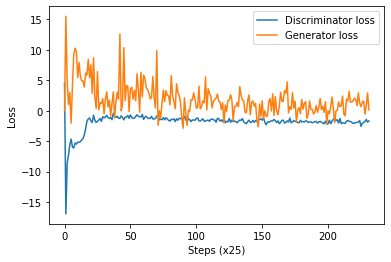

In [214]:
# Train WGAN-GP
gan = GAN(discriminator_steps = 0, lr = 0.0002, gradient_penalty_weight = 5)
gan.train(real_sequences, epochs = 100, step_log = 25)
gan.plot_history()

In [215]:
# Real sequences
OneHot = OneHot_Seq(letter_type = TASK_TYPE)
print(f'Example of real sequences:')
np.unique(OneHot.onehot_to_seq(real_sequences))[:5]

array(['ATGAAGAAGAAGGCTCGTAAGTCTGCTGGTGCTGCTTAGPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP',
       'ATGAAGAAGAAGGCTTAGPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP',
       'ATGAAGAAGAAGTAGPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP',
       ...,
       'ATGTTTTTGTAGTTGATTGGTCGTGTTTTGTCTGGTATTTTGTAGPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP',
       'ATGTTTTTGTCTTAGTTTTGGTTTGATATTTAGPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP',
       'ATGTTTTTGTGGGGTTAGCGTGCTTTGGTTTAGPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP'],
      dtype='<U75')

In [216]:
# Fake sequences
gan.show_sequences_history()

History of top scoring generated sequences... 

Step 0: 	 TTTTTTTTTTTTTTTTTTTTTTTTTTCTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTCT
Step 25: 	 TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Step 50: 	 ATPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
Step 75: 	 AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
Step 100: 	 TTTTTTTTTTTTTTTTTTTTTTTTTTPPPPPPPPCTTTTTTTTTTPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
Step 125: 	 TTTTTTTTPPPPPPPPPPGGGTTTTTTTPPPPPPPPPPPPPPPTTTTTTTPPPPPPPPPPPPPPPPPPPPPPPPP
Step 150: 	 AAGGGGGGGGGAAATTTTTTTTPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
Step 175: 	 ATTTTTGGAAATTTTTCCCCCCTTTCCGGGGGTTTGAAAATTTTTTPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
Step 200: 	 ATGGGTTTTGGGATTTTTGGGGAATTTTGGGGTTPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
Step 225: 	 AAATTGGCCPCCCCGATTGGGAATTTGCCCGGGGAAAATTGGGCPPPCCGGGGGGGGPPPPPPPPPPPPPPPPPP
Step 250: 	 ATGTTGCCCTTGGGTTGGATTTGGTTTGGPPPPPPPPPPCCGATTTTTGGGTTTGGPPPPPPPPP

### Previous runs: log

#### DNA sequences

Length: 75 in DNA (equal to 19 in amino acids)

Training samples: 7497

Parameters: 
gan = GAN(discriminator_steps = 0, lr = 0.0002, gradient_penalty_weight = 5)
gan.train(real_sequences, epochs = 100, step_log = 25)



```
Example of real sequences:

'ATGAAGAAGAAGGCTCGTAAGTCTGCTGGTGCTGCTTAGPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP'
'ATGAAGAAGAAGGCTTAGPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP'

```




```
History of top scoring generated sequences... 

Step 0: 	 TTTTTTTTTTTTTTTTTTTTTTTTTTCTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTCT
Step 25: 	 TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Step 50: 	 ATPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
Step 75: 	 AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
Step 100: 	 TTTTTTTTTTTTTTTTTTTTTTTTTTPPPPPPPPCTTTTTTTTTTPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
Step 125: 	 TTTTTTTTPPPPPPPPPPGGGTTTTTTTPPPPPPPPPPPPPPPTTTTTTTPPPPPPPPPPPPPPPPPPPPPPPPP
Step 150: 	 AAGGGGGGGGGAAATTTTTTTTPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
Step 175: 	 ATTTTTGGAAATTTTTCCCCCCTTTCCGGGGGTTTGAAAATTTTTTPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
Step 200: 	 ATGGGTTTTGGGATTTTTGGGGAATTTTGGGGTTPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
Step 225: 	 AAATTGGCCPCCCCGATTGGGAATTTGCCCGGGGAAAATTGGGCPPPCCGGGGGGGGPPPPPPPPPPPPPPPPPP
Step 250: 	 ATGTTGCCCTTGGGTTGGATTTGGTTTGGPPPPPPPPPPCCGATTTTTGGGTTTGGPPPPPPPPPPPPPPPPPPP
Step 275: 	 ATGTGGAATGGTTTGGAATTGGTTTGGCAAATGGGGTTTTGCPPPPAATGGTTTGPPPPPPPPPPPPPPPPPPPP

...

Step 5650: 	 ATGAAGCATAAGATTTTGCATCGTTTGTTGCAGGATTCTTCTTAGPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
Step 5675: 	 ATGGGTGCTTCTGCTTAGPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
Step 5700: 	 ATGAAGCATAAGATTTTGCATCGTTTGTTGCAGGATTCTTCTTCTTAGPPPPPPPPPPPPPPPPPPPPPPPPPPP
Step 5725: 	 ATGAAGCATAAGATTTTGCATCGTTTGTTGCAGGATTCTTCTTCTTAGPPPPPPPPPPPPPPPPPPPPPPPPPPP
Step 5750: 	 ATGGATTTTGATGAGATTTAGGAGGATTTGTTGTATAATCATAAGGAGGTTGCGAAGTATTAGPPPPPPPPPPPP
Step 5775: 	 ATGGCTCGTACTAAGCAGACTGCTCGTAAGTGTTAGPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

```



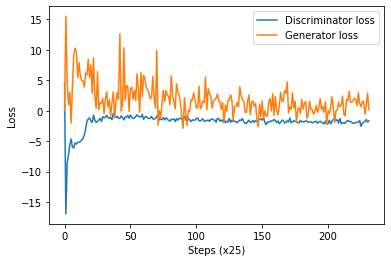

Short sequences:



```
Example of real sequences:
'ATGAAGCGTAAGTAGPPPPPPPPPPPPPPPPPP'
'ATGAAGGAGAAGTAGPPPPPPPPPPPPPPPPPP'
'ATGAAGGAGTCTTTGGTTTAGPPPPPPPPPPPP'
       
```



```
History of top scoring generated sequences... 

Step 0: 	 GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGTP
Step 25: 	 GGGGGGGGGGGGGGGGGGGGGGGGGGGPPPPPP
Step 50: 	 GGGGGGGGGGGGGGGGGGGGPPPPPPPPPPPPP
Step 75: 	 ATGGGGPPPPPAAAAAGGGGGPPPPPPPPPPPP
Step 100: 	 ATGATTTGGGGPPPATTGGPPPPPPPPPPPPPP
Step 125: 	 ATGTGGAATGGTTTGPPPPPPPPPPPPPPPPPP
Step 150: 	 ATGAATTGTAAGTPTTAGPPPPPPPPPPPPPPP
Step 175: 	 ATGAAGGATTGTAAGTAGPPPPPPPPPPPPPPP
Step 200: 	 ATGCTTCCTCAGACTCAGTAGPPPPPPPPPPPP
Step 225: 	 ATGGGTCAGTAGTTGTAGTAGPPPPPPPPPPPP
Step 250: 	 ATGTAGATTAAGTAGPPPPPPPPPPPPPPPPPP
Step 275: 	 ATGAAGTCTATTTAGPPPPPPPPPPPPPPPPPP
Step 300: 	 ATGTAGPGTTAGTAGPPPPPPPPPPPPPPPPPP
Step 325: 	 ATGGCTGCTGAGATGTAGTAGPPPPPPPPPPPP
Step 350: 	 ATGAAGGCTTCTTAGPPPPPPPPPPPPPPPPPP
Step 375: 	 ATGAAGPAGAAGTCTGCTTAGPPPPPPPPPPPP
Step 400: 	 ATGAATTAGTATTAGPPPPPPPPPPPPPPPPPP
Step 425: 	 ATGGATATTTCGTAGPPPPPPPPPPPPPPPPPP
Step 450: 	 ATGATTTAGCGTTAGTAGPPPPPPPPPPPPPPP
Step 475: 	 ATGAAGACTAAGTAGPPPPPPPPPPPPPPPPPP
Step 500: 	 ATGTAGAAGGAGTCTGATTAGPPPPPPPPPPPP
Step 525: 	 ATGCATGGTTAGATTTTTTAGPPPPPPPPPPPP
Step 550: 	 ATGTAGTTGATGTAGPPPPPPPPPPPPPPPPPP
Step 575: 	 ATGTAGGATAAGTAGPPPPPPPPPPPPPPPPPP
```





### Synthetic data - 4 amino acids only
Reduce the number of characters to 4 + 1 (for padding). 



Parameters



```
# Train WGAN-GP
gan = GAN(discriminator_steps = 1, lr = 0.0002, gradient_penalty_weight = 5)
gan.train(real_sequences, epochs = 2, step_log = 25)
gan.plot_history()
```



Training size: 10,000 sequences

Length: 16

Dimension: 512

Half and half split between two sequences, shuffled.

```
Real sequences: ARNDARNDNDNDNDND and ARNDARNDARNDARND 

History of top scoring generated sequences... 

Step 0: 	 ['DDDDDDDDDDDDDDDD']
Step 25: 	 ['ARNDARNDADNDADND']
Step 50: 	 ['ANNDDDDDDDDDDDDD']
Step 75: 	 ['NNNDDDDDDDDDDDDD']
Step 100: 	 ['NNNNNNNNNNNNNNNN']
Step 125: 	 ['NNNNNNNNNNNNNNNN']
Step 150: 	 ['NNNNNNNNNNNNNNNN']
Step 175: 	 ['NNNNNNNNNNNNNNNN']
Step 200: 	 ['NNNNNNNNNNNNNNNN']
Step 225: 	 ['NNNNNNNNNNNNNNNN']
Step 250: 	 ['NNNNNNNNNNNNNNNN']
Step 275: 	 ['NNNNNNNNNNNNNNNN']
Step 300: 	 ['NNNNNNNNNNNNNNNN']
```


After many trials that failed (random initialization):



```
History of top scoring generated sequences... 

Step 0: 	 ['RRRRRRRRRRRRRRRD']
Step 25: 	 ['DDDDDDDDDDDDDDDD']
Step 50: 	 ['ARRAAAAAAAAAARRD']
Step 75: 	 ['ARNDARNDARNDARND']
Step 100: 	 ['ARNDARNDARNDNDND']
Step 125: 	 ['ARNDARNDARNDARND']
Step 150: 	 ['NRNDNRNDNDNDNDND']
Step 175: 	 ['NRNDNRNDNDNDNDND']
Step 200: 	 ['ARNDARNDNDNDNDND']
Step 225: 	 ['ARNDARNDNDNDNDND']
Step 250: 	 ['ARNDARNDNDNDNDND']
Step 275: 	 ['ARNDARNDNDNDNDND']
Step 300: 	 ['ARNDARNDNDNDNDND']
```




Training size: 2,000 sequences

Length: 8

Dimension: 512



```
Real sequence: ARNDARND

History of top scoring generated sequences... 

Step 0: 	 ['RRRRNRND']
Step 25: 	 ['ARNDAAND']
Step 50: 	 ['ARNDARND']
Step 75: 	 ['ARNDARND']
Step 100: 	 ['ARNDARND']
Step 125: 	 ['ARNDARND']
Step 150: 	 ['ARNDARND']

```
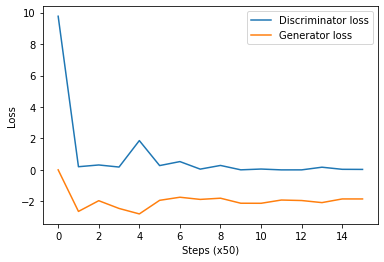


Training size: 10,0000 sequences.


Length: 20

```
Real sequence:
ARNDARNDARNDARNDARND

History of top scoring generated sequences... 

Step 0: 	 ['RDDDDDDDDDDDDDDDDDDD']
Step 50: 	 ['RRRRRRRRRRRRRAAAAAAA']
Step 100: 	 ['RRRRRRRRRRRRRRRRRAAA']
Step 150: 	 ['RRRRRRRRRRRRRRRRRAAA']
Step 200: 	 ['RRRRRRRRRRRRRRRRRAAA']
Step 250: 	 ['RRRRRRRRRRRRRRRRRAAA']
Step 300: 	 ['RRRRRRRRRRRRRRRRRAAA']

```


#### Synthetic data

Training data: repeats 2000 times the following 20-amino acid long sequence.




```
Real sequence:
`RGGRLRGGRLRGGRLRGGRL`

History of top scoring generated sequences... 

Step 0: 	 ['TTTAAAAAAAAAAAAAAAAC']
Step 50: 	 ['TTTTTTTTTTTTTTTTTTCC']
Step 100: 	 ['TTTTTTTTTTTTTTTTTTCC']
Step 150: 	 ['TTTTTTTTTTTTTTTTTTCC']
Step 200: 	 ['TTTTTTTTTTTTTTTTTTCC']
Step 250: 	 ['TTTTTTTTTTTTTTTTTTCC']
Step 300: 	 ['TTTTTTTTTTTTTTTTTTCC']
```



#### Decrease length



```
Maximum RAM resource on Colab Pro
SEQ_LENGTH * DIM < 6400
```




LEN = 20

DIM = 320
```
History of top scoring generated sequences... 

Step 0: 	 ['CCCCCCCCCCCCCCCCCCTN']
Step 50: 	 ['NNNNNNNNNNNNNNNNNNNN']
Step 100: 	 ['NNNNNNNNNNNNNNNNNNNN']
Step 150: 	 ['NNNNNNNNNNNNNNNNNNNN']
Step 200: 	 ['NNNNNNNNNNNNNNNNNNNN']
Step 250: 	 ['NNNNNNNNNNNNNNNNNNNN']
Step 300: 	 ['NNNNNNNNNNNNNNNNNNNN']
Step 350: 	 ['NNNNNNNNNNNNNNNNNNNN']
```



**Hyperparameters: History**

18506 samples, 2 epochs, sequence_length = < 50 aa, pretrained discriminator 0 times

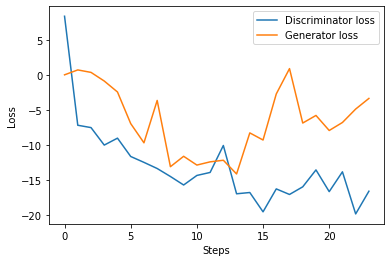





```
History of top scoring generated sequences... 

Step 0: 	 ['SSSIISSISISISISSSSIIISSISSISIISSISSSSIISSSISISSSDD']
Step 50: 	 ['KVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV']
Step 100: 	 ['KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKSS']
Step 150: 	 ['KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKSSSS']
Step 200: 	 ['KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKSSKSSSSK']
Step 250: 	 ['KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK']
Step 300: 	 ['KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK']
Step 350: 	 ['KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK']
Step 400: 	 ['KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK']
Step 450: 	 ['KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK']
Step 500: 	 ['KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK']
Step 550: 	 ['KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK']
Step 600: 	 ['KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK']
Step 650: 	 ['KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK']
Step 700: 	 ['KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK']
Step 750: 	 ['KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK']
Step 800: 	 ['KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK']
Step 850: 	 ['KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK']
Step 900: 	 ['KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK']
Step 950: 	 ['KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK']
Step 1000: 	 ['KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK']
Step 1050: 	 ['KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK']
Step 1100: 	 ['KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK']
Step 1150: 	 ['KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK']
```




With gradient penalty, 2000 samples, 200 epochs, sequence length = 40-50 aa, pretrained discriminator 5 times

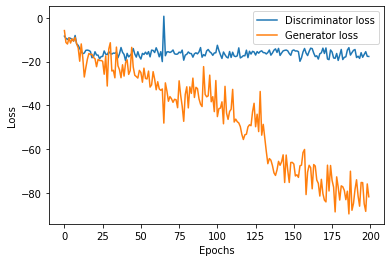

With gradient penalty, 1000 samples, 100 epochs, sequence length = 40-50 aa

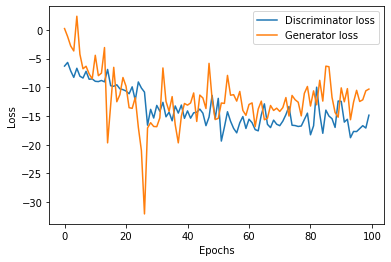

With gradient penalty, 1000 samples, 100 epochs,  sequence length = 3-50 aa

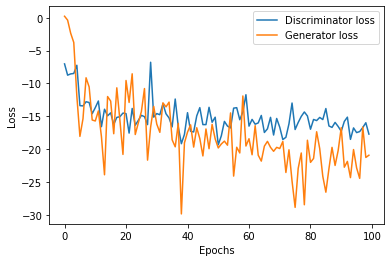

Without gradient penalty, 500 samples, 20 epochs

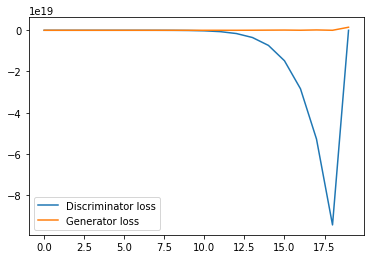